# Introduction

The data is provided by [Home Credit](https://www.homecredit.net/about-us.aspx) - International consumer finance provider focusing on responsible lending to people with little or no credit history. 

Predicting whether or not a client will repay a loan or have difficulty is a critical business need, so they hired me to analyse the data and make several prediction models.

# Data
We have 7 different csv files of data:


- application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

- bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

- bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

- previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

- POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

- credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

- installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

# EDA

In [1]:
import numpy as np
import pandas as pd 

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as  mpatches

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, precision_score,roc_auc_score
from sklearn.metrics import  confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
import lightgbm as lgb
import sklearn.metrics as metrics
import timeit
from sklearn.decomposition import PCA
from boruta import BorutaPy
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
import optuna
import joblib
from sklearn.model_selection import RepeatedStratifiedKFold

We will start investigating the main dataset with Target column which labels the loan if it is payed back (0) or not (1).

In [2]:
df = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
print('Training data shape: ', df.shape)
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df.head())


Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

The Train data has 300K rows and 122 columns

In [3]:
df_test = pd.read_csv("/kaggle/input/home-credit-default-risk/application_test.csv")
print('Testing data shape: ', df_test.shape)
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df_test.head())

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

Test data has 48k rows and 121 column, the test dataset doesn't have target column.

In [4]:
del(df_test)

## Analyse target column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

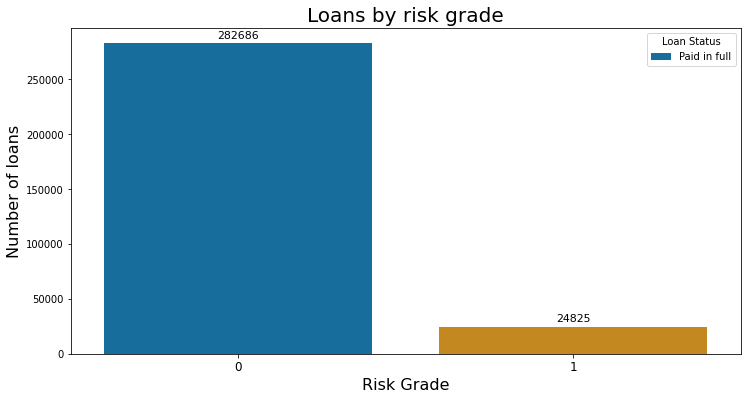

In [5]:
fig = plt.figure(figsize = (12,6))
ax = sns.countplot(x ='TARGET',data=df, palette='colorblind')
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
    
plt.xticks(fontsize=12)
ax.set_xlabel("Risk Grade", fontsize = 16)
ax.set_ylabel("Number of loans", fontsize = 16)
ax.set_title("Loans by risk grade", fontsize = 20)
plt.legend(title="Loan Status", labels=[ 'Paid in full', 'At risk'])
plt.show()

From this graph, we see this is an imbalanced class problem. More loans were repaid on time, than not repaid on time.

## Column types

In dataset we have 106 numerical (float64 and int64) and 16 categorical columns.

In [6]:
df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Let's see how many unique categories have each column.

In [7]:
# Number of unique classes in each object column
df.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the columns have rather small number of categories, so it will not be difficult to encode them.

# Analyse each column

The problem we always want to check before creating prediction model if data have some anomalies. For example some values might be mistyped or might be error in measuring equipment or could be valid but extreme difference from the others. So for that reason we will take closer look at each column.

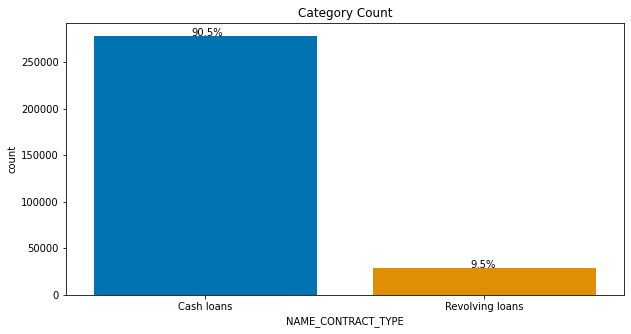

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='NAME_CONTRACT_TYPE',data=df, order=df['NAME_CONTRACT_TYPE'].value_counts().index, 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.35, p.get_height()))
plt.show()

Most of the loans are Cash loans and about 10% are revolving loans.

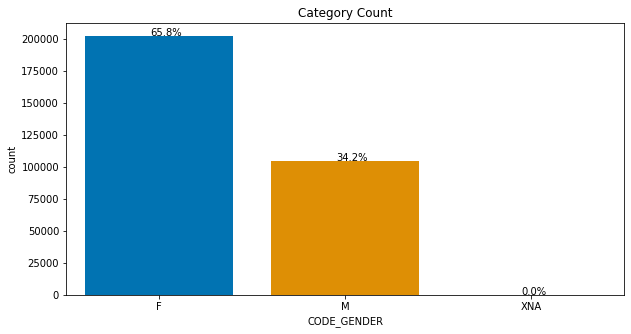

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [9]:

fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='CODE_GENDER',data=df, order=df['CODE_GENDER'].value_counts().index, 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.35, p.get_height()))
plt.show()
df['CODE_GENDER'].value_counts()

Interesting third group XNA, need later investigation what it means.

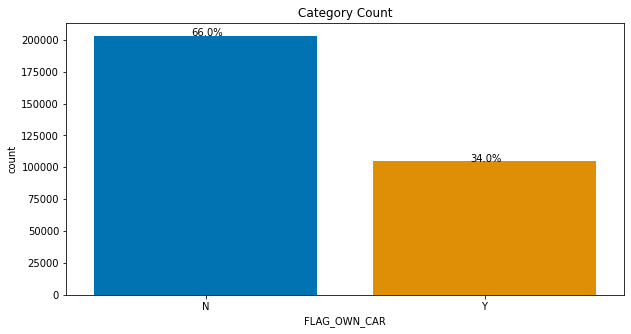

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='FLAG_OWN_CAR',data=df, order=df['FLAG_OWN_CAR'].value_counts().index, 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.35, p.get_height()))
plt.show()


2/3 of people don't have a car

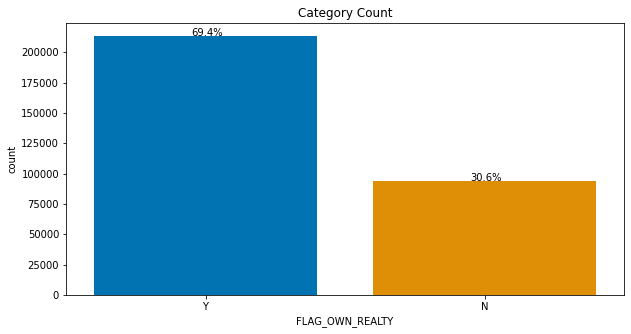

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='FLAG_OWN_REALTY',data=df, order=df['FLAG_OWN_REALTY'].value_counts().index, 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.35, p.get_height()))
plt.show()

70% of borrowers owns a house or flat.

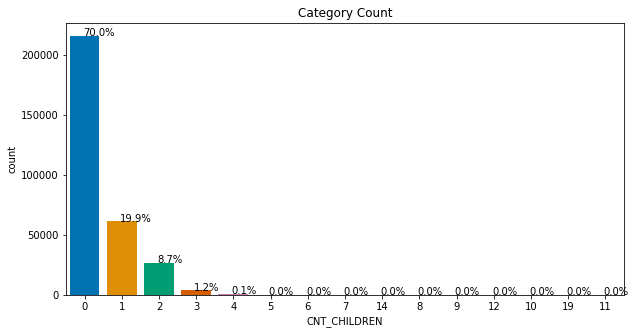

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='CNT_CHILDREN',data=df, order=df['CNT_CHILDREN'].value_counts().index, 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.35, p.get_height()))
plt.show()

70% of borrowers don't have children

In [13]:
pd.options.display.float_format = "{:.2f}".format
df.AMT_INCOME_TOTAL.describe()

count      307511.00
mean       168797.92
std        237123.15
min         25650.00
25%        112500.00
50%        147150.00
75%        202500.00
max     117000000.00
Name: AMT_INCOME_TOTAL, dtype: float64

The income of the clients are very different. The minimum value is 25,650, median is 147,150 and maximum is 117,000,000

count    307511.00
mean     599026.00
std      402490.78
min       45000.00
25%      270000.00
50%      513531.00
75%      808650.00
max     4050000.00
Name: AMT_CREDIT, dtype: float64

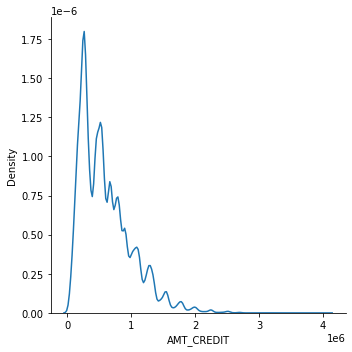

In [14]:

sns.displot(df, x="AMT_CREDIT", kind="kde")
pd.options.display.float_format = "{:.2f}".format
df.AMT_CREDIT.describe()

Credit amount of the loan minimum is 45,000, median is 513,531 and max is 4,050,000.

count   307499.00
mean     27108.57
std      14493.74
min       1615.50
25%      16524.00
50%      24903.00
75%      34596.00
max     258025.50
Name: AMT_ANNUITY, dtype: float64

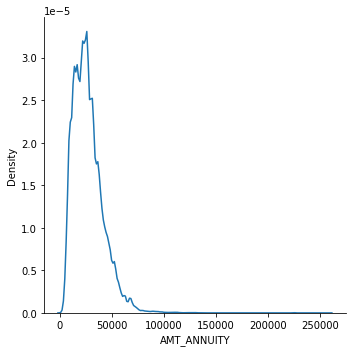

In [15]:
sns.displot(df, x="AMT_ANNUITY", kind="kde")
pd.options.display.float_format = "{:.2f}".format
df.AMT_ANNUITY.describe()

Loan annuity minimum values is 1615, the median is 24,903 and maximum is 258025

count    307233.00
mean     538396.21
std      369446.46
min       40500.00
25%      238500.00
50%      450000.00
75%      679500.00
max     4050000.00
Name: AMT_GOODS_PRICE, dtype: float64

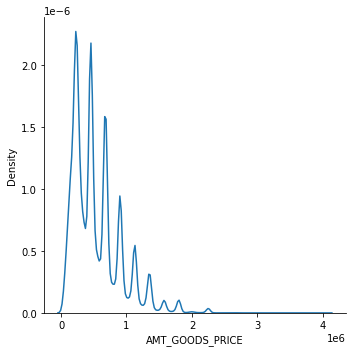

In [16]:
sns.displot(df, x="AMT_GOODS_PRICE", kind="kde")
pd.options.display.float_format = "{:.2f}".format
df.AMT_GOODS_PRICE.describe()

For consumer loans it is the price of the goods for which the loan is given starts from 40500, the median is 450,000 and the max price is 4,050,000.

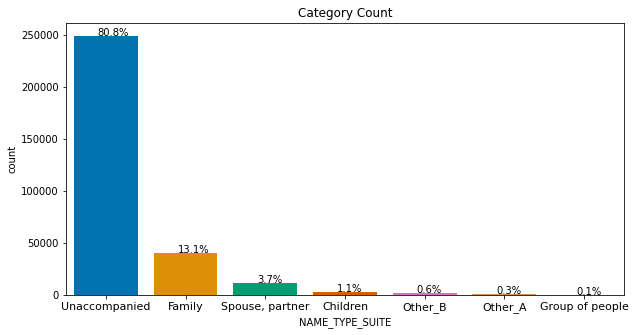

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='NAME_TYPE_SUITE',data=df, order=df['NAME_TYPE_SUITE'].value_counts().index, 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.3, p.get_height()))
plt.xticks(fontsize=11)
plt.show()

80% of people took the loan alone and others had someone accompanying them.

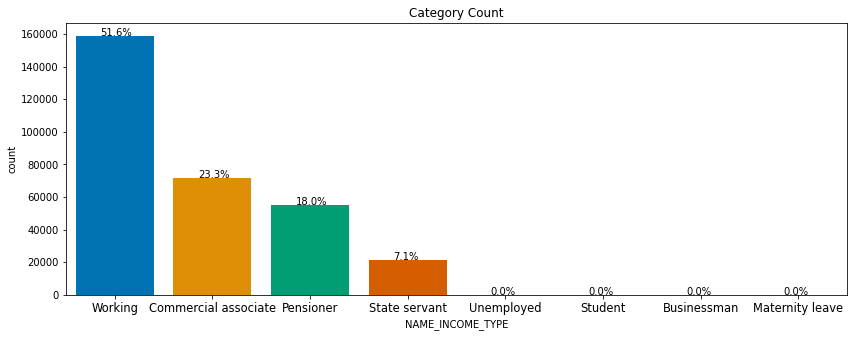

In [18]:

fig, ax = plt.subplots(figsize=(14,5))
sns.countplot(x='NAME_INCOME_TYPE',data=df, order=df['NAME_INCOME_TYPE'].value_counts().index, 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.25, p.get_height()))
plt.xticks(fontsize=11.5)
plt.show()

Clients income type are mostly Working (51.6%), Commercial Associate (23.3%), Pensioner(18%) and State servant(7.1%).

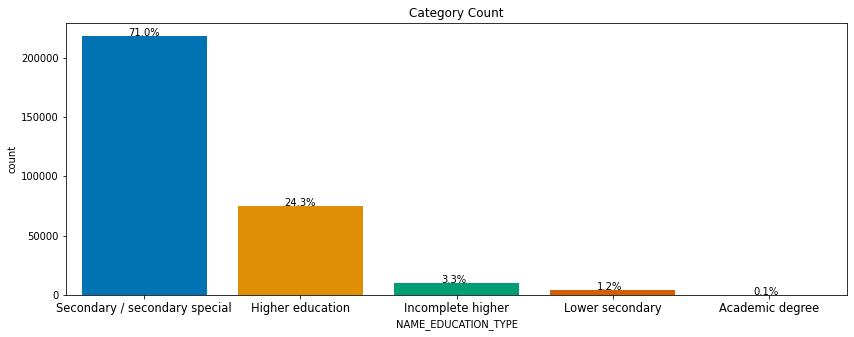

In [19]:
fig, ax = plt.subplots(figsize=(14,5))
sns.countplot(x='NAME_EDUCATION_TYPE',data=df, order=df['NAME_EDUCATION_TYPE'].value_counts().index, 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.3, p.get_height()))
plt.xticks(fontsize=11.5)
plt.show()

71% of people have Secondary/ secondary special education, 24.3% have higher education and others have incomplete higher, lower secondary and academic degree.

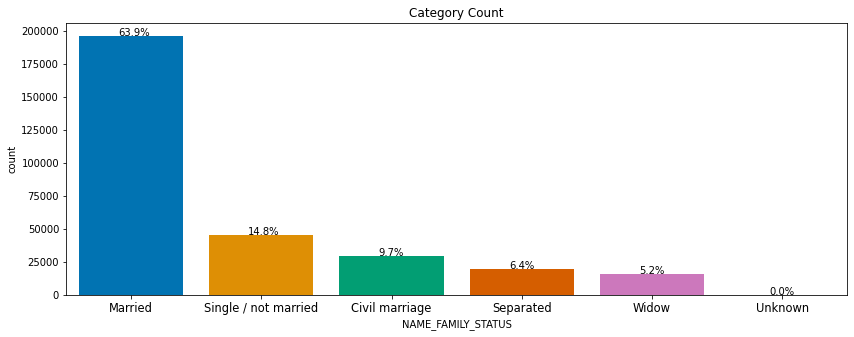

In [20]:
fig, ax = plt.subplots(figsize=(14,5))
sns.countplot(x='NAME_FAMILY_STATUS',data=df, order=df['NAME_FAMILY_STATUS'].value_counts().index, 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.3, p.get_height()))
plt.xticks(fontsize=11.5)
plt.show()

In the column family status 63.9% are married, 14.8% single/not married, 

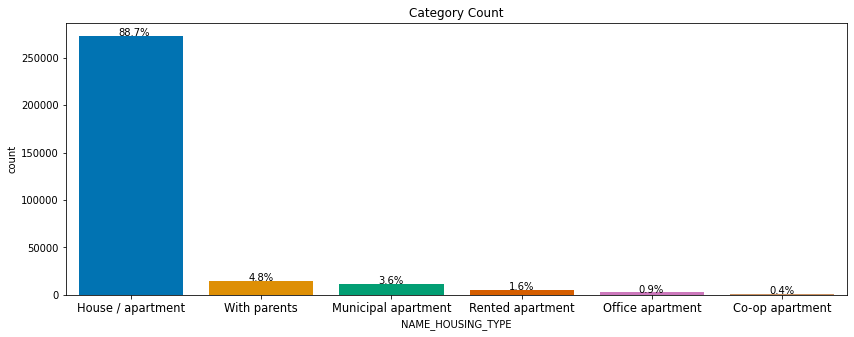

In [21]:
fig, ax = plt.subplots(figsize=(14,5))
sns.countplot(x='NAME_HOUSING_TYPE',data=df, order=df['NAME_HOUSING_TYPE'].value_counts().index, 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.3, p.get_height()))
plt.xticks(fontsize=11.5)
plt.show()

Majority (88%) of clients lives in house or apartament of their own.

count   307511.00
mean        43.94
std         11.96
min         20.52
25%         34.01
50%         43.15
75%         53.92
max         69.12
Name: DAYS_BIRTH, dtype: float64

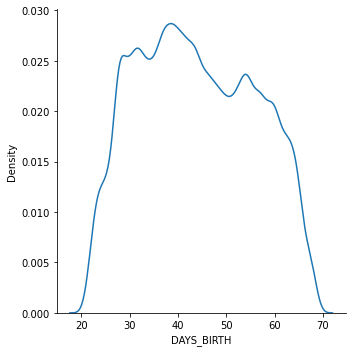

In [22]:
sns.displot(df.DAYS_BIRTH/-365, kind="kde")
pd.options.display.float_format = "{:.2f}".format
(df.DAYS_BIRTH/-365).describe()

The age of clients are between 20 and 69 years old, with median age 43.

count   307511.00
mean     63815.05
std     141275.77
min     -17912.00
25%      -2760.00
50%      -1213.00
75%       -289.00
max     365243.00
Name: DAYS_EMPLOYED, dtype: float64

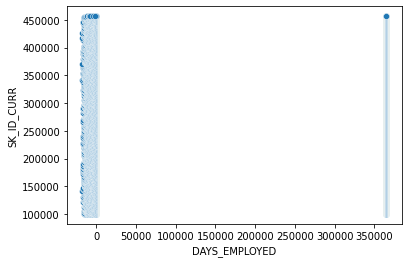

In [23]:
sns.scatterplot(x='DAYS_EMPLOYED', y='SK_ID_CURR', data=df)
pd.options.display.float_format = "{:.2f}".format
(df.DAYS_EMPLOYED).describe()

We can see big difference between values lower that zero and value over 365243. Let's count how many values we have with max number.

In [24]:
print('Number of anomalies is', df['DAYS_EMPLOYED'][df['DAYS_EMPLOYED'] == 365243].count())
df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

Number of anomalies is 55374


There is 55k rows with those specific days, which is more that 1000 year. It seems wrong and I decided to set those values to null and later flag them.

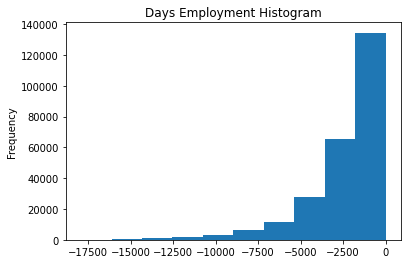

In [25]:
df['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');

Now day of employment looks correct

count   307511.00
mean     -4986.12
std       3522.89
min     -24672.00
25%      -7479.50
50%      -4504.00
75%      -2010.00
max          0.00
Name: DAYS_REGISTRATION, dtype: float64

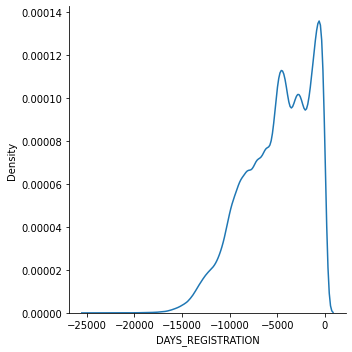

In [26]:
sns.displot(df.DAYS_REGISTRATION, kind="kde")
pd.options.display.float_format = "{:.2f}".format
(df.DAYS_REGISTRATION).describe()

The days before the application did client change his registration looks similar to days employment graph.

In [27]:
print('Training data shape: ', df.shape)
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df.head())

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637.00,-3648.00,-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188.00,-1186.00,-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,135000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225.00,-4260.00,-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00

count   307511.00
mean     -2994.20
std       1509.45
min      -7197.00
25%      -4299.00
50%      -3254.00
75%      -1720.00
max          0.00
Name: DAYS_ID_PUBLISH, dtype: float64

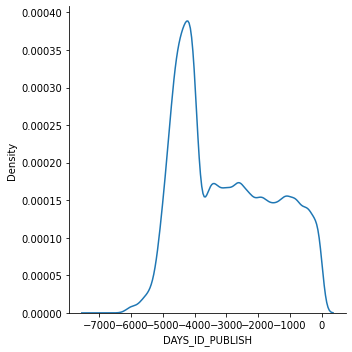

In [28]:
sns.displot(df.DAYS_ID_PUBLISH, kind="kde")
pd.options.display.float_format = "{:.2f}".format
(df.DAYS_ID_PUBLISH).describe()

Days before the application did client change the identity document with which he applied looks normal.

count   104582.00
mean        12.06
std         11.94
min          0.00
25%          5.00
50%          9.00
75%         15.00
max         91.00
Name: OWN_CAR_AGE, dtype: float64

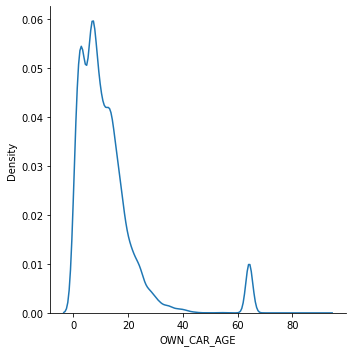

In [29]:
sns.displot(df.OWN_CAR_AGE, kind="kde")
pd.options.display.float_format = "{:.2f}".format
(df.OWN_CAR_AGE).describe()

It seems some people have very old historical cars, but it is still possible car age.

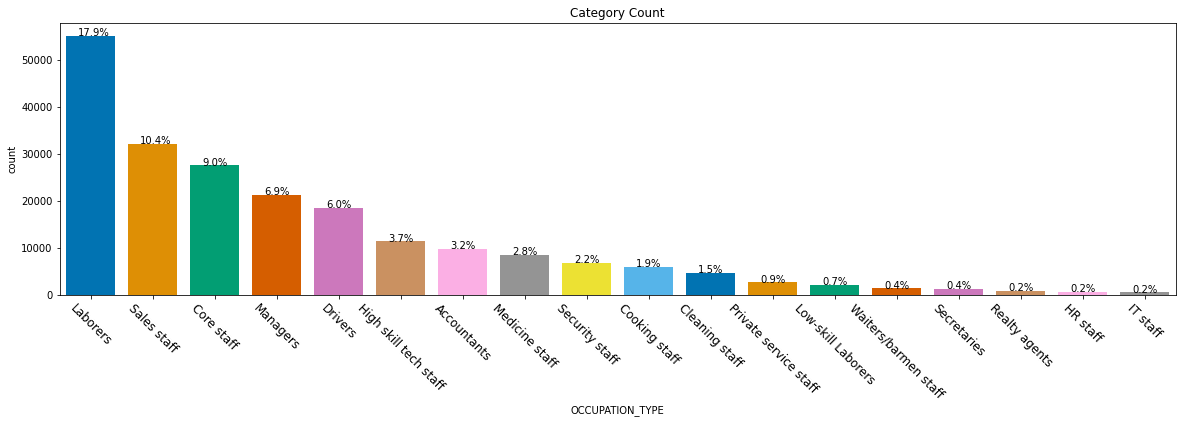

In [30]:
fig, ax= plt.subplots(figsize=(20,5))
sns.countplot(x='OCCUPATION_TYPE',data=df, order=df['OCCUPATION_TYPE'].value_counts().index, 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.2, p.get_height()))
plt.xticks(fontsize=12, rotation = 315)
plt.show()

Where are many Occupation types are in the graph

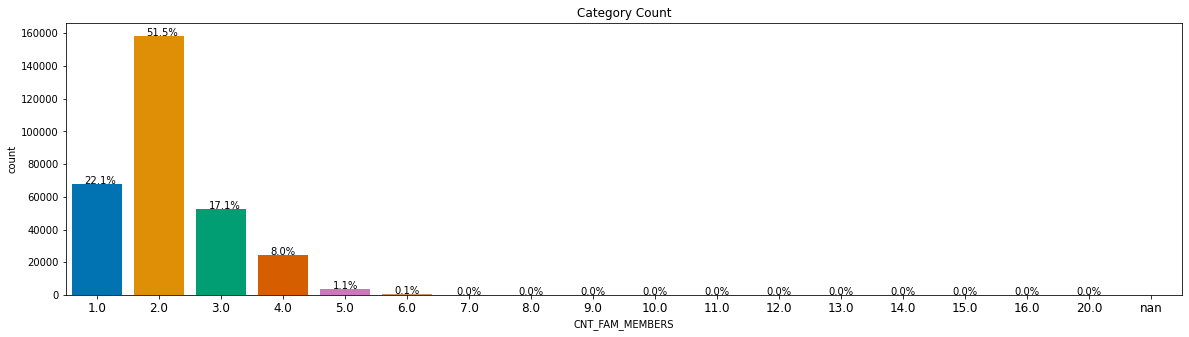

In [31]:
fig, ax= plt.subplots(figsize=(20,5))
sns.countplot(x='CNT_FAM_MEMBERS',data=df, order=np.sort(df['CNT_FAM_MEMBERS'].unique()), 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.2, p.get_height()))
plt.xticks(fontsize=12)
plt.show()

Most of the family size are less or equal 5 persons.

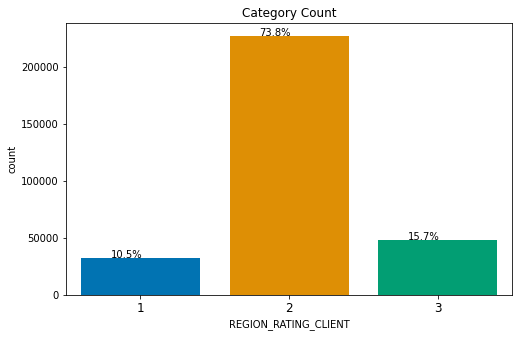

In [32]:
fig, ax= plt.subplots(figsize=(8,5))
sns.countplot(x='REGION_RATING_CLIENT',data=df, order=np.sort(df['REGION_RATING_CLIENT'].unique()), 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.2, p.get_height()))
plt.xticks(fontsize=12)
plt.show()

There are 3 groups of regions and the biggest is group number 2.

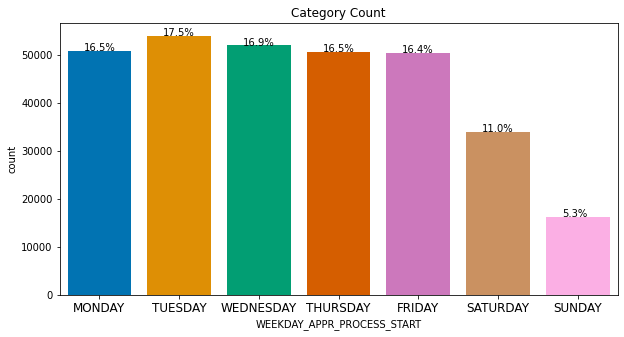

In [33]:
fig, ax= plt.subplots(figsize=(10,5))
sns.countplot(x='WEEKDAY_APPR_PROCESS_START',data=df, order=['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY'], 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.2, p.get_height()))
plt.xticks(fontsize=12)
plt.show()

Clients usually applied for loan from Monday until Friday.

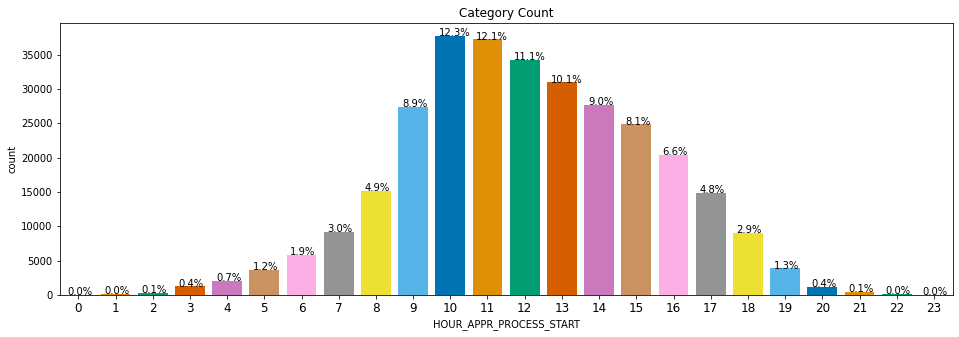

In [34]:

fig, ax= plt.subplots(figsize=(16,5))
sns.countplot(x='HOUR_APPR_PROCESS_START',data=df,  order=np.sort(df['HOUR_APPR_PROCESS_START'].unique()), 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.1, p.get_height()))
plt.xticks(fontsize=12)
plt.show()

Client apply for the loan usually on working hours.

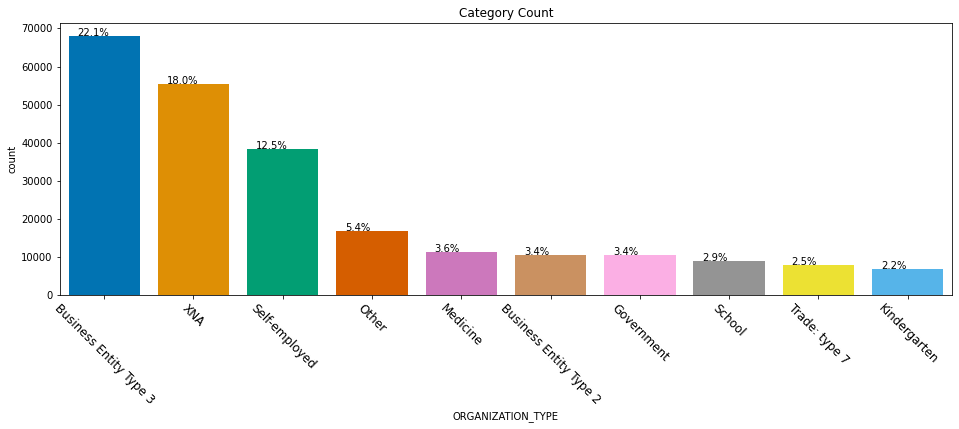

In [35]:
fig, ax= plt.subplots(figsize=(16,5))
sns.countplot(x='ORGANIZATION_TYPE',data=df,  order=df['ORGANIZATION_TYPE'].value_counts().index[:10], 
              palette="colorblind", 
              saturation=1).set_title("Category Count")


for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+0.1, p.get_height()))
plt.xticks(fontsize=12, rotation=-45)
plt.show()

Biggest group of organization type where clients works is business entity type-3

There are more columns in this dataset, however I analysed the most importand from this dataset.

# Baseline

For this dataset best evaluation the metric is ROC AUC. Receiver Operating Characteristic (ROC) Area Under Curve (AUC) is a measure of how accurately a model can distinguish between two classes (0 and 1, also known as binary classification). It is a metric that evaluates the performance of a classification model. The AUC represents the probability that the model will be able to predict the class of a randomly chosen sample correctly. The higher the AUC, the better the model is at distinguishing between the two classes. A perfect AUC is 1, and a score of 0.5 indicates that the model is no better than random guessing.

For a naive baseline, we could guess the same value for all examples on the testing set.  We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This  will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5. So we know that our base line is  0.5 and we want to get the prediction results as closer to 1 as possible.


# Random Forest Tree

Define all column names, split into numerical and categorical.

In [104]:
numerical_features = [
    'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE',
       'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE',
       'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'COMMONAREA_AVG',
       'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI',
       'ELEVATORS_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI',
       'ENTRANCES_MODE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE',
       'FLAG_WORK_PHONE', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI',
       'FLOORSMAX_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI',
       'FLOORSMIN_MODE', 'HOUR_APPR_PROCESS_START', 'LANDAREA_AVG',
       'LANDAREA_MEDI', 'LANDAREA_MODE', 'LIVE_CITY_NOT_WORK_CITY',
       'LIVE_REGION_NOT_WORK_REGION', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_AVG',
       'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'SK_ID_CURR', 'TOTALAREA_MODE',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_AVG',
       'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE'
]
categorical_features = [
       'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
]
label_column = 'TARGET'

Spliting the data into training set and testing set

In [37]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify=df[label_column])

Defining data transformer

In [38]:
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="constant")),
        (
            "categorical_encoder",
            OneHotEncoder(handle_unknown='ignore'),
        ),
    ]
)

numerical_transformer = Pipeline(
    steps=[
        ("numerical_imputer", SimpleImputer(strategy="constant", fill_value = -999999)),
        (
            "numerical_scaler",
            StandardScaler(),
        ),
    ]
)

preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features,
        ),
        
    ]
)

Let's use Random Forest model

In [39]:
model = RandomForestClassifier(n_estimators = 100, random_state = 50, n_jobs = -1,class_weight='balanced')


In [40]:
pipe = Pipeline([("preprocessor", preprocessor),
                  ("model", model)
                ])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                 

Training the model

In [41]:
%%time
pipe.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

CPU times: user 3min 18s, sys: 1.94 s, total: 3min 20s
Wall time: 55.3 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                 

In [42]:
def print_results( y_pred, y_test):
    print('Test ROC AUC score: ' + str(roc_auc_score(y_test, y_pred)))

In [43]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])

print_results(y_pred, y_test)

Test ROC AUC score: 0.5


The results are bad and very similar to baseline. Let's see the confusion matrix.

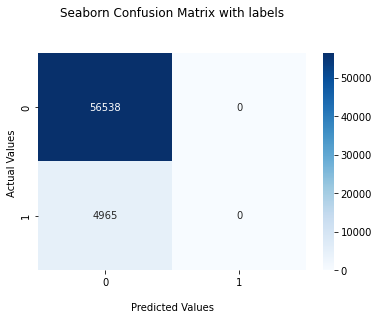

In [44]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])

confm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confm, annot=True, cmap='Blues',fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0 ,1])
ax.yaxis.set_ticklabels([0 ,1])

plt.show()

The model almost always predicts 0 class, so it is not good. We need to try another model.

Lets't use Light GBM model to make predictions.

In [45]:
model = lgb.LGBMClassifier(n_estimators=100, objective = 'binary', 
                           class_weight = 'balanced', learning_rate = 0.03, 
                           reg_alpha = 0.1, reg_lambda = 0.1, 
                           subsample = 0.8, n_jobs = -1, random_state = 50)


In [46]:
light = Pipeline([("preprocessor", preprocessor),

                  ("model", model)
                ])
light

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                 

In [47]:
%%time
light.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

CPU times: user 46.3 s, sys: 1.29 s, total: 47.6 s
Wall time: 15.8 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                 

In [48]:
y_test = test_data[label_column].to_numpy()
y_pred = light.predict(test_data[numerical_features + categorical_features])

print_results(y_pred, y_test)

Test ROC AUC score: 0.6879220231955857


The results are promising and much betters than base line. Let's plot confusion matrix.

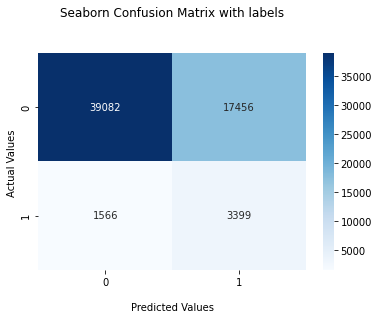

In [49]:
y_test = test_data[label_column].to_numpy()
y_pred = light.predict(test_data[numerical_features + categorical_features])

confm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confm, annot=True, cmap='Blues',fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0 ,1])
ax.yaxis.set_ticklabels([0 ,1])

plt.show()

Many labels were predicted wrong, so we have a lot of space for improvement.

# Feature engineering from with Bureau data.

There are more related tables which are usefull to have. We will start from bureau set, which has data from previous loans that client got from other institutions and that were reported to Credit Bureau.

In [50]:
def preview_bureau():
    bureau = pd.read_csv("/kaggle/input/home-credit-default-risk/bureau.csv")
    print('Training data shape: ', bureau.shape)
    with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
        display(bureau.head())

preview_bureau()

Training data shape:  (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,91323.00,0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.00,NaN,NaN,0,225000.00,171342.00,NaN,0.00,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,464323.50,NaN,NaN,0.00,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.00,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.00,NaN,77674.50,0,2700000.00,NaN,NaN,0.00,Consumer credit,-21,NaN


In [51]:
def preview_bureau_balance():
    bureau_balance = pd.read_csv("/kaggle/input/home-credit-default-risk/bureau_balance.csv")
    print('Training data shape: ', bureau_balance.shape)
    with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
        display(bureau_balance.head())
preview_bureau_balance()

Training data shape:  (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


It seems that data has many columns for single account, so I will group data by ID. Aggregation for numeric data will be mean value and for categoricat -  the most frequent category. Later I will left join to the main dataframe and see if it gave better results.

In [52]:
%%time
def merge_bureau():
    df = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
    bureau = pd.read_csv("/kaggle/input/home-credit-default-risk/bureau.csv")
    bureau_balance = pd.read_csv("/kaggle/input/home-credit-default-risk/bureau_balance.csv")
    
    bureau_balance = bureau_balance.groupby(['SK_ID_BUREAU']).agg(
        MONTHS_BALANCE =("MONTHS_BALANCE", lambda x:round(x.mean(), 0)),
        STATUS=("STATUS", lambda x:x.value_counts().index[0])
    ).reset_index()
    
    bureau = bureau.merge(bureau_balance, on='SK_ID_BUREAU', how='left')
    
    bureau = bureau.groupby(['SK_ID_CURR']).agg(
        CREDIT_ACTIVE=("CREDIT_ACTIVE", lambda x:x.value_counts().index[0]),
        CREDIT_CURRENCY=("CREDIT_CURRENCY", lambda x:x.value_counts().index[0]),
        DAYS_CREDIT=("DAYS_CREDIT", lambda x:round(x.mean(), 0)),
        CREDIT_DAY_OVERDUE=("CREDIT_DAY_OVERDUE",  lambda x:round(x.mean(), 0)),
        DAYS_CREDIT_ENDDATE=("DAYS_CREDIT_ENDDATE",  lambda x:round(x.mean(), 0)),
        DAYS_ENDDATE_FACT=("DAYS_ENDDATE_FACT",  lambda x:round(x.mean(), 0)),
        CNT_CREDIT_PROLONG=("CNT_CREDIT_PROLONG",  lambda x:round(x.mean(), 0)),
        AMT_CREDIT_SUM=("AMT_CREDIT_SUM",  lambda x:round(x.mean(), 0)),
        AMT_CREDIT_SUM_DEBT=("AMT_CREDIT_SUM_DEBT",  lambda x:round(x.mean(), 0)),
        AMT_CREDIT_SUM_LIMIT=("AMT_CREDIT_SUM_LIMIT",  lambda x:round(x.mean(), 0)),
        AMT_CREDIT_SUM_OVERDUE=("AMT_CREDIT_SUM_OVERDUE",  lambda x:round(x.mean(), 0)),
        CREDIT_TYPE=("CREDIT_TYPE",  lambda x:x.value_counts().index[0]),
        DAYS_CREDIT_UPDATE=("DAYS_CREDIT_UPDATE",  lambda x:round(x.mean(), 0)),
        AMT_ANNUITY_B=("AMT_ANNUITY",  lambda x:round(x.mean(), 0)),
        MONTHS_BALANCE=("MONTHS_BALANCE", lambda x:round(x.mean(), 0)),
        STATUS=("STATUS", lambda x:x.value_counts().index[0] if (not x.value_counts().empty) else 'none')
    ).reset_index()

    df = df.merge(bureau, on='SK_ID_CURR', how='left')
    return df


df = merge_bureau()

CPU times: user 17min 31s, sys: 5 s, total: 17min 36s
Wall time: 17min 36s


In [53]:
df.shape

(307511, 138)

In [54]:
numerical_features = [
       'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE',
       'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE',
       'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'COMMONAREA_AVG',
       'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI',
       'ELEVATORS_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI',
       'ENTRANCES_MODE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE',
       'FLAG_WORK_PHONE', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI',
       'FLOORSMAX_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI',
       'FLOORSMIN_MODE', 'HOUR_APPR_PROCESS_START', 'LANDAREA_AVG',
       'LANDAREA_MEDI', 'LANDAREA_MODE', 'LIVE_CITY_NOT_WORK_CITY',
       'LIVE_REGION_NOT_WORK_REGION', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_AVG',
       'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'SK_ID_CURR', 'TOTALAREA_MODE',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_AVG',
       'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'DAYS_CREDIT_UPDATE', 'MONTHS_BALANCE', 'AMT_ANNUITY_B'
]
categorical_features = [
       'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
       'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE','STATUS'
]
label_column = 'TARGET'

In [55]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify=df[label_column])

In [56]:
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="constant")),
        (
            "categorical_encoder",
            OneHotEncoder(handle_unknown='ignore'),
        ),
    ]
)

numerical_transformer = Pipeline(
    steps=[
        ("numerical_imputer", SimpleImputer(strategy="constant", fill_value = -999999)),
        (
            "numerical_scaler",
            StandardScaler(),
        ),
    ]
)

preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features,
        ),
        
    ]
)

In [57]:
model = lgb.LGBMClassifier(n_estimators=100, objective = 'binary', 
                           class_weight = 'balanced', learning_rate = 0.03, 
                           reg_alpha = 0.1, reg_lambda = 0.1, 
                           subsample = 0.8, n_jobs = -1, random_state = 50)


In [58]:
light = Pipeline([("preprocessor", preprocessor),

                  ("model", model)
                ])
light

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                 

In [59]:
%%time
light.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

CPU times: user 54.7 s, sys: 1.78 s, total: 56.5 s
Wall time: 19.1 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                 

In [60]:
def print_results( y_pred, y_test):
    print('Test accuracy score: ' + str(accuracy_score( y_test,y_pred)))
    print('Test precision score: ' + str(precision_score(  y_test, y_pred)))
    print('Test ROC AUC score: ' + str(roc_auc_score(y_test, y_pred)))

In [61]:
y_test = test_data[label_column].to_numpy()
y_pred = light.predict(test_data[numerical_features + categorical_features])

print_results(y_pred, y_test)

Test accuracy score: 0.6905029022974489
Test precision score: 0.16194137433925998
Test ROC AUC score: 0.6851430778475969


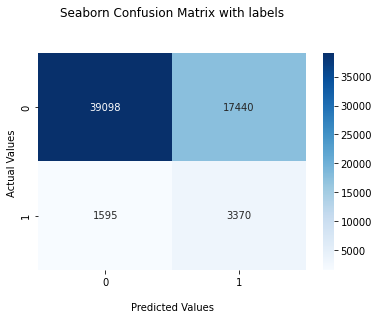

In [62]:
y_test = test_data[label_column].to_numpy()
y_pred = light.predict(test_data[numerical_features + categorical_features])

confm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confm, annot=True, cmap='Blues',fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0 ,1])
ax.yaxis.set_ticklabels([0 ,1])

plt.show()

The ROC AUC score after joining Bureau tables didn't change so we will try to join previous application data.

# Feature engineering from with previous application data.

We have 4 more csv file and they all have SK_ID_CURR column, so we can directly join to the main application dataset. I have grouped all 4 datasets by SK_ID_CURR and keep most frequent value for categories and mean value for numerical data, because joining all data makes duplicates of main data and instead of 300k row I would get >10 millions of rows. 

In [63]:
def preview_previous_appl():
    prev = pd.read_csv("/kaggle/input/grouped/grouped/previous_application_grouped.csv")
    print('Training data shape: ', prev.shape)
    with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
        display(prev.head())

preview_previous_appl()

Training data shape:  (338857, 36)


,SK_ID_CURR,P_NAME_CONTRACT_TYPE,P_AMT_ANNUITY,P_AMT_APPLICATION,P_AMT_CREDIT,P_AMT_DOWN_PAYMENT,P_AMT_GOODS_PRICE,P_WEEKDAY_APPR_PROCESS_START,P_HOUR_APPR_PROCESS_START,P_FLAG_LAST_APPL_PER_CONTRACT,P_NFLAG_LAST_APPL_IN_DAY,P_RATE_DOWN_PAYMENT,P_RATE_INTEREST_PRIMARY,P_RATE_INTEREST_PRIVILEGED,P_NAME_CASH_LOAN_PURPOSE,P_NAME_CONTRACT_STATUS,P_DAYS_DECISION,P_NAME_PAYMENT_TYPE,P_CODE_REJECT_REASON,P_NAME_TYPE_SUITE,P_NAME_CLIENT_TYPE,P_NAME_GOODS_CATEGORY,P_NAME_PORTFOLIO,P_NAME_PRODUCT_TYPE,P_CHANNEL_TYPE,P_SELLERPLACE_AREA,P_NAME_SELLER_INDUSTRY,P_CNT_PAYMENT,P_NAME_YIELD_GROUP,P_PRODUCT_COMBINATION,P_DAYS_FIRST_DRAWING,P_DAYS_FIRST_DUE,P_DAYS_LAST_DUE_1ST_VERSION,P_DAYS_LAST_DUE,P_DAYS_TERMINATION,P_NFLAG_INSURED_ON_APPROVAL
0,100001,Consumer loans,3951.00,24836.00,23787.00,2520.00,24836.00,FRIDAY,13.00,Y,1.00,0.00,NaN,NaN,XAP,Approved,-1740.00,Cash through the bank,XAP,Family,Refreshed,Mobile,POS,XNA,Country-wide,23.00,Connectivity,8.00,high,POS mobile with interest,365243.00,-1709.00,-1499.00,-1619.00,-1612.00,0.00
1,100002,Consumer loans,9252.00,179055.00,179055.00,0.00,179055.00,SATURDAY,9.00,Y,1.00,0.00,NaN,NaN,XAP,Approved,-606.00,XNA,XAP,none,New,Vehicles,POS,XNA,Stone,500.00,Auto technology,24.00,low_normal,POS other with interest,365243.00,-565.00,125.00,-25.00,-17.00,0.00
2,100003,Consumer loans,56554.00,435436.00,484191.00,3442.00,435436.00,FRIDAY,15.00,Y,1.00,0.00,NaN,NaN,XAP,Approved,-1305.00,Cash through the bank,XAP,Family,Refreshed,XNA,POS,XNA,Credit and cash offices,533.00,XNA,10.00,middle,Cash X-Sell: low,365243.00,-1274.00,-1004.00,-1054.00,-1047.00,1.00
3,100004,Consumer loans,5357.00,24282.00,20106.00,4860.00,24282.00,FRIDAY,5.00,Y,1.00,0.00,NaN,NaN,XAP,Approved,-815.00,Cash through the bank,XAP,Unaccompanied,New,Mobile,POS,XNA,Regional / Local,30.00,Connectivity,4.00,middle,POS mobile without interest,365243.00,-784.00,-694.00,-724.00,-714.00,0.00
4,100005,Cash loans,4813.00,22309.00,20077.00,4464.00,44618.00,FRIDAY,10.00,Y,1.00,0.00,NaN,NaN,XNA,Canceled,-536.00,XNA,XAP,none,Repeater,XNA,XNA,XNA,Credit and cash offices,18.00,XNA,12.00,XNA,Cash,365243.00,-706.00,-376.00,-466.00,-460.00,0.00


In [64]:
def merge_bureau():
    df = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
    previous_application = pd.read_csv("/kaggle/input/grouped/grouped/previous_application_grouped.csv")
    
    df = df.merge(previous_application, on='SK_ID_CURR', how='left')
    return df


df = merge_bureau()

In [65]:
def give_results( y_pred, y_test):
    return roc_auc_score(y_test, y_pred)

In [66]:
def print_results(roc_auc):
    print('Test ROC AUC score: ' + str(roc_auc))

In [67]:
add_numerical = [
    'P_AMT_ANNUITY', 'P_AMT_APPLICATION',
    'P_AMT_CREDIT', 'P_AMT_DOWN_PAYMENT', 'P_AMT_GOODS_PRICE',
    'P_CNT_PAYMENT', 'P_DAYS_DECISION', 'P_DAYS_FIRST_DRAWING',
    'P_DAYS_FIRST_DUE', 'P_DAYS_LAST_DUE',
    'P_DAYS_LAST_DUE_1ST_VERSION', 'P_DAYS_TERMINATION',
    'P_HOUR_APPR_PROCESS_START', 'P_NFLAG_INSURED_ON_APPROVAL',
    'P_NFLAG_LAST_APPL_IN_DAY', 'P_RATE_DOWN_PAYMENT',
    'P_RATE_INTEREST_PRIMARY', 'P_RATE_INTEREST_PRIVILEGED',
    'P_SELLERPLACE_AREA'
]
add_categorical = [
    'P_NAME_CONTRACT_TYPE', 'P_WEEKDAY_APPR_PROCESS_START',
    'P_FLAG_LAST_APPL_PER_CONTRACT', 'P_NAME_CASH_LOAN_PURPOSE',
    'P_NAME_CONTRACT_STATUS', 'P_NAME_PAYMENT_TYPE', 'P_CODE_REJECT_REASON',
    'P_NAME_TYPE_SUITE', 'P_NAME_CLIENT_TYPE', 'P_NAME_GOODS_CATEGORY',
    'P_NAME_PORTFOLIO', 'P_NAME_PRODUCT_TYPE', 'P_CHANNEL_TYPE',
    'P_NAME_SELLER_INDUSTRY', 'P_NAME_YIELD_GROUP',
    'P_PRODUCT_COMBINATION'
]


In [68]:
def run_pipeline (df, model, add_numerical = [], add_categorical = []):
    numerical_features = [
        'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
        'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
        'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
        'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE',
        'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE',
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'COMMONAREA_AVG',
        'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'DAYS_BIRTH',
        'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
        'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE',
        'DEF_60_CNT_SOCIAL_CIRCLE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI',
        'ELEVATORS_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI',
        'ENTRANCES_MODE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
        'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
        'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
        'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
        'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
        'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
        'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
        'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
        'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE',
        'FLAG_WORK_PHONE', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI',
        'FLOORSMAX_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI',
        'FLOORSMIN_MODE', 'HOUR_APPR_PROCESS_START', 'LANDAREA_AVG',
        'LANDAREA_MEDI', 'LANDAREA_MODE', 'LIVE_CITY_NOT_WORK_CITY',
        'LIVE_REGION_NOT_WORK_REGION', 'LIVINGAPARTMENTS_AVG',
        'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_AVG',
        'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_AVG',
        'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
        'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE',
        'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE',
        'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
        'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
        'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'SK_ID_CURR', 'TOTALAREA_MODE',
        'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_AVG',
        'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE'
    ]
    categorical_features = [
        'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
        'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
        'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'

    ]
    label_column = 'TARGET'
    
    numerical_features = numerical_features + add_numerical
    categorical_features = categorical_features + add_categorical
    
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify=df[label_column])
    
    categorical_transformer = Pipeline(
        steps=[
            ("categorical_imputer", SimpleImputer(strategy="constant")),
            ("categorical_encoder",OneHotEncoder(handle_unknown='ignore'))])

    numerical_transformer = Pipeline(
        steps=[
            ("numerical_imputer", SimpleImputer(strategy="constant", fill_value = -999999)),
            ("numerical_scaler",StandardScaler())])

    preprocessor = ColumnTransformer(
        [("categorical", categorical_transformer, categorical_features),
         ("numerical", numerical_transformer, numerical_features)])

    pipe = Pipeline([("preprocessor", preprocessor),
                      ("model", model) ])
    
    pipe.fit(train_data[numerical_features + categorical_features], train_data[label_column])
    
    y_test = test_data[label_column].to_numpy()
    y_pred = pipe.predict(test_data[numerical_features + categorical_features])
    
    return give_results(y_pred, y_test)

In [69]:
model = lgb.LGBMClassifier(n_estimators=100, objective = 'binary', 
                           class_weight = 'balanced', learning_rate = 0.03, 
                           reg_alpha = 0.1, reg_lambda = 0.1, 
                           subsample = 0.8, n_jobs = -1, random_state = 50)


In [70]:
roc_auc = run_pipeline(df, model, add_numerical,add_categorical )
print_results(roc_auc)

Test ROC AUC score: 0.6922203273920308


In [71]:
def preview_POS_CASH_balance():
    POS_CASH_balance = pd.read_csv("/kaggle/input/grouped/grouped/POS_CASH_balance_grouped.csv")
    print('Training data shape: ', POS_CASH_balance.shape)
    with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
        display(POS_CASH_balance.head())

preview_POS_CASH_balance()

Training data shape:  (337252, 7)


,SK_ID_CURR,PC_NAME_CONTRACT_STATUS,PC_MONTHS_BALANCE,PC_CNT_INSTALMENT,PC_CNT_INSTALMENT_FUTURE,PC_SK_DPD,PC_SK_DPD_DEF
0,100001,Active,-73.00,4.00,1.00,1.00,1.00
1,100002,Active,-10.00,24.00,15.00,0.00,0.00
2,100003,Active,-44.00,10.00,6.00,0.00,0.00
3,100004,Active,-26.00,4.00,2.00,0.00,0.00
4,100005,Active,-20.00,12.00,7.00,0.00,0.00


In [72]:
def merge_POS_CASH_balance():
    df = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
    POS_CASH_balance = pd.read_csv("/kaggle/input/grouped/grouped/POS_CASH_balance_grouped.csv")
    
    df = df.merge(POS_CASH_balance, on='SK_ID_CURR', how='left')
    return df


df = merge_POS_CASH_balance()

In [73]:
add_numerical = [
    'PC_MONTHS_BALANCE','PC_CNT_INSTALMENT',
    'PC_CNT_INSTALMENT_FUTURE','PC_SK_DPD',
    'PC_SK_DPD_DEF'
]
add_categorical = [
    'PC_NAME_CONTRACT_STATUS'
]

In [74]:
roc_auc = run_pipeline(df, model, add_numerical,add_categorical )
print_results(roc_auc)

Test ROC AUC score: 0.6908858133433023


Join credit_card_balance dataset


In [75]:
def preview_credit_card_balance():
    credit_card_balance = pd.read_csv("/kaggle/input/grouped/grouped/credit_card_balance_grouped.csv")
    print('Training data shape: ', credit_card_balance.shape)
    with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
        display(credit_card_balance.head())

preview_credit_card_balance()

Training data shape:  (103558, 22)


,SK_ID_CURR,CCB_NAME_CONTRACT_STATUS,CCB_MONTHS_BALANCE,CCB_AMT_BALANCE,CCB_AMT_CREDIT_LIMIT_ACTUAL,CCB_AMT_DRAWINGS_ATM_CURRENT,CCB_AMT_DRAWINGS_CURRENT,CCB_AMT_DRAWINGS_OTHER_CURRENT,CCB_AMT_DRAWINGS_POS_CURRENT,CCB_AMT_INST_MIN_REGULARITY,CCB_AMT_PAYMENT_CURRENT,CCB_AMT_PAYMENT_TOTAL_CURRENT,CCB_AMT_RECEIVABLE_PRINCIPAL,CCB_AMT_RECIVABLE,CCB_AMT_TOTAL_RECEIVABLE,CCB_CNT_DRAWINGS_ATM_CURRENT,CCB_CNT_DRAWINGS_CURRENT,CCB_CNT_DRAWINGS_OTHER_CURRENT,CCB_CNT_DRAWINGS_POS_CURRENT,CCB_CNT_INSTALMENT_MATURE_CUM,CCB_SK_DPD,CCB_SK_DPD_DEF
0,100006,Active,-4.00,0.00,270000.00,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0.00,NaN,NaN,0.00,0.00,0.00
1,100011,Active,-38.00,54482.00,164189.00,2432.00,2432.00,0.00,0.00,3956.00,4843.00,4520.00,52402.00,54433.00,54433.00,0.00,0.00,0.00,0.00,26.00,0.00,0.00
2,100013,Active,-48.00,18160.00,131719.00,6350.00,5953.00,0.00,0.00,1455.00,7168.00,6817.00,17256.00,18101.00,18101.00,0.00,0.00,0.00,0.00,19.00,0.00,0.00
3,100021,Completed,-10.00,0.00,675000.00,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0.00,NaN,NaN,0.00,0.00,0.00
4,100023,Active,-8.00,0.00,135000.00,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0.00,NaN,NaN,0.00,0.00,0.00


In [76]:
def merge_credit_card_balance():
    df = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
    credit_card_balance = pd.read_csv("/kaggle/input/grouped/grouped/credit_card_balance_grouped.csv")    
    df = df.merge(credit_card_balance, on='SK_ID_CURR', how='left')
    return df


df = merge_credit_card_balance()

In [77]:
add_numerical = [
    'CCB_AMT_BALANCE', 'CCB_AMT_CREDIT_LIMIT_ACTUAL',
    'CCB_AMT_DRAWINGS_ATM_CURRENT', 'CCB_AMT_DRAWINGS_CURRENT',
    'CCB_AMT_DRAWINGS_OTHER_CURRENT', 'CCB_AMT_DRAWINGS_POS_CURRENT',
    'CCB_AMT_INST_MIN_REGULARITY', 'CCB_AMT_PAYMENT_CURRENT',
    'CCB_AMT_PAYMENT_TOTAL_CURRENT', 'CCB_AMT_RECEIVABLE_PRINCIPAL',
    'CCB_AMT_RECIVABLE', 'CCB_AMT_TOTAL_RECEIVABLE',
    'CCB_CNT_DRAWINGS_ATM_CURRENT', 'CCB_CNT_DRAWINGS_CURRENT',
    'CCB_CNT_DRAWINGS_OTHER_CURRENT', 'CCB_CNT_DRAWINGS_POS_CURRENT',
    'CCB_CNT_INSTALMENT_MATURE_CUM', 'CCB_MONTHS_BALANCE',
    'CCB_SK_DPD', 'CCB_SK_DPD_DEF'
]
add_categorical = [
    'CCB_NAME_CONTRACT_STATUS'
]

In [78]:
roc_auc = run_pipeline(df, model, add_numerical,add_categorical )
print_results(roc_auc)

Test ROC AUC score: 0.6901994370227591


In [79]:
def preview_credit_card_balance():
    payments = pd.read_csv("/kaggle/input/grouped/grouped/installments_payments_grouped.csv")
    print('Training data shape: ', payments.shape)
    with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
        display(payments.head())
preview_credit_card_balance()

Training data shape:  (339587, 7)


,SK_ID_CURR,IP_NUM_INSTALMENT_VERSION,IP_NUM_INSTALMENT_NUMBER,IP_DAYS_INSTALMENT,IP_DAYS_ENTRY_PAYMENT,IP_AMT_INSTALMENT,IP_AMT_PAYMENT
0,100001,1.00,3.00,-2188.00,-2195.00,5885.00,5885.00
1,100002,1.00,10.00,-295.00,-315.00,11559.00,11559.00
2,100003,1.00,5.00,-1378.00,-1385.00,64755.00,64755.00
3,100004,1.00,2.00,-754.00,-762.00,7096.00,7096.00
4,100005,1.00,5.00,-586.00,-610.00,6240.00,6240.00


In [80]:
def merge_installments_payments():
    df = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
    payments = pd.read_csv("/kaggle/input/grouped/grouped/installments_payments_grouped.csv")
    df = df.merge(payments, on='SK_ID_CURR', how='left')
    return df


df = merge_installments_payments()

In [81]:
add_numerical = [
    'IP_AMT_INSTALMENT',
    'IP_AMT_PAYMENT', 'IP_DAYS_ENTRY_PAYMENT', 'IP_DAYS_INSTALMENT',
    'IP_NUM_INSTALMENT_NUMBER', 'IP_NUM_INSTALMENT_VERSION',
]
add_categorical = [
    
]

In [82]:
roc_auc = run_pipeline(df, model, add_numerical,add_categorical )
print_results(roc_auc)

Test ROC AUC score: 0.6859127818105707


# Join all grouped data
Let's JOIN  all grouped dataset and see the results

In [83]:
def merge_grouped():
    df = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
    previous_application = pd.read_csv("/kaggle/input/grouped/grouped/previous_application_grouped.csv")
    POS_CASH_balance = pd.read_csv("/kaggle/input/grouped/grouped/POS_CASH_balance_grouped.csv")
    credit_card_balance = pd.read_csv("/kaggle/input/grouped/grouped/credit_card_balance_grouped.csv")    
    payments = pd.read_csv("/kaggle/input/grouped/grouped/installments_payments_grouped.csv")
    
    df = df.merge(previous_application, on='SK_ID_CURR', how='left')
    df = df.merge(POS_CASH_balance, on='SK_ID_CURR', how='left')
    df = df.merge(credit_card_balance, on='SK_ID_CURR', how='left')
    df = df.merge(payments, on='SK_ID_CURR', how='left')
    return df


df = merge_grouped()

In [84]:
add_numerical = [
    'P_AMT_ANNUITY', 'P_AMT_APPLICATION',
    'P_AMT_CREDIT', 'P_AMT_DOWN_PAYMENT', 'P_AMT_GOODS_PRICE',
    'P_CNT_PAYMENT', 'P_DAYS_DECISION', 'P_DAYS_FIRST_DRAWING',
    'P_DAYS_FIRST_DUE', 'P_DAYS_LAST_DUE',
    'P_DAYS_LAST_DUE_1ST_VERSION', 'P_DAYS_TERMINATION',
    'P_HOUR_APPR_PROCESS_START', 'P_NFLAG_INSURED_ON_APPROVAL',
    'P_NFLAG_LAST_APPL_IN_DAY', 'P_RATE_DOWN_PAYMENT',
    'P_RATE_INTEREST_PRIMARY', 'P_RATE_INTEREST_PRIVILEGED',
    'P_SELLERPLACE_AREA',
    'PC_MONTHS_BALANCE','PC_CNT_INSTALMENT',
    'PC_CNT_INSTALMENT_FUTURE','PC_SK_DPD',
    'PC_SK_DPD_DEF',
    'CCB_AMT_BALANCE', 'CCB_AMT_CREDIT_LIMIT_ACTUAL',
    'CCB_AMT_DRAWINGS_ATM_CURRENT', 'CCB_AMT_DRAWINGS_CURRENT',
    'CCB_AMT_DRAWINGS_OTHER_CURRENT', 'CCB_AMT_DRAWINGS_POS_CURRENT',
    'CCB_AMT_INST_MIN_REGULARITY', 'CCB_AMT_PAYMENT_CURRENT',
    'CCB_AMT_PAYMENT_TOTAL_CURRENT', 'CCB_AMT_RECEIVABLE_PRINCIPAL',
    'CCB_AMT_RECIVABLE', 'CCB_AMT_TOTAL_RECEIVABLE',
    'CCB_CNT_DRAWINGS_ATM_CURRENT', 'CCB_CNT_DRAWINGS_CURRENT',
    'CCB_CNT_DRAWINGS_OTHER_CURRENT', 'CCB_CNT_DRAWINGS_POS_CURRENT',
    'CCB_CNT_INSTALMENT_MATURE_CUM', 'CCB_MONTHS_BALANCE',
    'CCB_SK_DPD', 'CCB_SK_DPD_DEF',
    'IP_AMT_INSTALMENT',
    'IP_AMT_PAYMENT', 'IP_DAYS_ENTRY_PAYMENT', 'IP_DAYS_INSTALMENT',
    'IP_NUM_INSTALMENT_NUMBER', 'IP_NUM_INSTALMENT_VERSION'
    
]
add_categorical = [
    'P_NAME_CONTRACT_TYPE', 'P_WEEKDAY_APPR_PROCESS_START',
    'P_FLAG_LAST_APPL_PER_CONTRACT', 'P_NAME_CASH_LOAN_PURPOSE',
    'P_NAME_CONTRACT_STATUS', 'P_NAME_PAYMENT_TYPE', 'P_CODE_REJECT_REASON',
    'P_NAME_TYPE_SUITE', 'P_NAME_CLIENT_TYPE', 'P_NAME_GOODS_CATEGORY',
    'P_NAME_PORTFOLIO', 'P_NAME_PRODUCT_TYPE', 'P_CHANNEL_TYPE',
    'P_NAME_SELLER_INDUSTRY', 'P_NAME_YIELD_GROUP',
    'P_PRODUCT_COMBINATION',
    'PC_NAME_CONTRACT_STATUS',
    'CCB_NAME_CONTRACT_STATUS'
]

In [85]:
roc_auc = run_pipeline(df, model, add_numerical,add_categorical )
print_results(roc_auc)

Test ROC AUC score: 0.6949684456803055


We reached the best result so far, so we will use this data further.

# Model tuning

In [86]:
numerical_features = [
    'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
    'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE',
    'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'COMMONAREA_AVG',
    'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'DAYS_BIRTH',
    'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
    'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI',
    'ELEVATORS_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI',
    'ENTRANCES_MODE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE',
    'FLAG_WORK_PHONE', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI',
    'FLOORSMAX_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI',
    'FLOORSMIN_MODE', 'HOUR_APPR_PROCESS_START', 'LANDAREA_AVG',
    'LANDAREA_MEDI', 'LANDAREA_MODE', 'LIVE_CITY_NOT_WORK_CITY',
    'LIVE_REGION_NOT_WORK_REGION', 'LIVINGAPARTMENTS_AVG',
    'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_AVG',
    'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE',
    'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'SK_ID_CURR', 'TOTALAREA_MODE',
    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_AVG',
    'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
    'P_AMT_ANNUITY', 'P_AMT_APPLICATION',
    'P_AMT_CREDIT', 'P_AMT_DOWN_PAYMENT', 'P_AMT_GOODS_PRICE',
    'P_CNT_PAYMENT', 'P_DAYS_DECISION', 'P_DAYS_FIRST_DRAWING',
    'P_DAYS_FIRST_DUE', 'P_DAYS_LAST_DUE',
    'P_DAYS_LAST_DUE_1ST_VERSION', 'P_DAYS_TERMINATION',
    'P_HOUR_APPR_PROCESS_START', 'P_NFLAG_INSURED_ON_APPROVAL',
    'P_NFLAG_LAST_APPL_IN_DAY', 'P_RATE_DOWN_PAYMENT',
    'P_RATE_INTEREST_PRIMARY', 'P_RATE_INTEREST_PRIVILEGED',
    'P_SELLERPLACE_AREA',
    'PC_MONTHS_BALANCE','PC_CNT_INSTALMENT',
    'PC_CNT_INSTALMENT_FUTURE','PC_SK_DPD',
    'PC_SK_DPD_DEF',
    'CCB_AMT_BALANCE', 'CCB_AMT_CREDIT_LIMIT_ACTUAL',
    'CCB_AMT_DRAWINGS_ATM_CURRENT', 'CCB_AMT_DRAWINGS_CURRENT',
    'CCB_AMT_DRAWINGS_OTHER_CURRENT', 'CCB_AMT_DRAWINGS_POS_CURRENT',
    'CCB_AMT_INST_MIN_REGULARITY', 'CCB_AMT_PAYMENT_CURRENT',
    'CCB_AMT_PAYMENT_TOTAL_CURRENT', 'CCB_AMT_RECEIVABLE_PRINCIPAL',
    'CCB_AMT_RECIVABLE', 'CCB_AMT_TOTAL_RECEIVABLE',
    'CCB_CNT_DRAWINGS_ATM_CURRENT', 'CCB_CNT_DRAWINGS_CURRENT',
    'CCB_CNT_DRAWINGS_OTHER_CURRENT', 'CCB_CNT_DRAWINGS_POS_CURRENT',
    'CCB_CNT_INSTALMENT_MATURE_CUM', 'CCB_MONTHS_BALANCE',
    'CCB_SK_DPD', 'CCB_SK_DPD_DEF',
    'IP_AMT_INSTALMENT',
    'IP_AMT_PAYMENT', 'IP_DAYS_ENTRY_PAYMENT', 'IP_DAYS_INSTALMENT',
    'IP_NUM_INSTALMENT_NUMBER', 'IP_NUM_INSTALMENT_VERSION'
]
categorical_features = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
    'P_NAME_CONTRACT_TYPE', 'P_WEEKDAY_APPR_PROCESS_START',
    'P_FLAG_LAST_APPL_PER_CONTRACT', 'P_NAME_CASH_LOAN_PURPOSE',
    'P_NAME_CONTRACT_STATUS', 'P_NAME_PAYMENT_TYPE', 'P_CODE_REJECT_REASON',
    'P_NAME_TYPE_SUITE', 'P_NAME_CLIENT_TYPE', 'P_NAME_GOODS_CATEGORY',
    'P_NAME_PORTFOLIO', 'P_NAME_PRODUCT_TYPE', 'P_CHANNEL_TYPE',
    'P_NAME_SELLER_INDUSTRY', 'P_NAME_YIELD_GROUP',
    'P_PRODUCT_COMBINATION',
    'PC_NAME_CONTRACT_STATUS',
    'CCB_NAME_CONTRACT_STATUS'

]
label_column = 'TARGET'


categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="constant")),
        ("categorical_encoder",OneHotEncoder(handle_unknown='ignore'))])

numerical_transformer = Pipeline(
    steps=[
        ("numerical_imputer", SimpleImputer(strategy="constant", fill_value = -999999)),
        ("numerical_scaler",StandardScaler())])

preprocessor = ColumnTransformer(
    [("categorical", categorical_transformer, categorical_features),
     ("numerical", numerical_transformer, numerical_features)])


In [87]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify=df[label_column])
pipe = Pipeline([("preprocessor", preprocessor) ])

In [88]:
X_train = preprocessor.fit_transform(train_data[numerical_features + categorical_features])
y_train = train_data[label_column]
X_test = preprocessor.transform(test_data[numerical_features + categorical_features])
y_test = test_data[label_column]

In [89]:
model = lgb.LGBMClassifier( n_estimators = 1000,objective = 'binary', 
                           class_weight = 'balanced',
                           reg_alpha = 0.1, reg_lambda = 0.1, 
                           n_jobs = -1, random_state = 50,
                            
)

In [90]:
def objective(trial):
 
    param_grid = {

        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
    }


    model.set_params(**param_grid)
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
        early_stopping_rounds=100,
        callbacks=[
            optuna.integration.LightGBMPruningCallback(trial, "auc")
        ]
    )



    with open("Default_model{}.pkl".format(trial.number), "wb") as fout:
        joblib.dump(model, fout)
    
    y_test_real = y_test
    y_pred = model.predict(X_test)

    return roc_auc_score(y_test_real, y_pred)

In [91]:
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2023-01-08 18:39:57,929] A new study created in memory with name: no-name-5189f012-a874-4da2-8201-9fcf3a305a9c


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-01-08 18:40:21,481] Trial 0 finished with value: 0.7047667964192519 and parameters: {'learning_rate': 0.13850864093238927, 'max_depth': 11}. Best is trial 0 with value: 0.7047667964192519.
[I 2023-01-08 18:40:45,030] Trial 1 finished with value: 0.7034307915142813 and parameters: {'learning_rate': 0.15732917584340483, 'max_depth': 9}. Best is trial 0 with value: 0.7047667964192519.
[I 2023-01-08 18:41:03,868] Trial 2 finished with value: 0.7008256030566935 and parameters: {'learning_rate': 0.27606050664127507, 'max_depth': 7}. Best is trial 0 with value: 0.7047667964192519.
[I 2023-01-08 18:41:24,532] Trial 3 finished with value: 0.7029932171918916 and parameters: {'learning_rate': 0.16896754176371004, 'max_depth': 10}. Best is trial 0 with value: 0.7047667964192519.
[I 2023-01-08 18:41:45,646] Trial 4 finished with value: 0.7046798511794169 and parameters: {'learning_rate': 0.16605750616490114, 'max_depth': 12}. Best is trial 0 with value: 0.7047667964192519.
[I 2023-01-08 18:

In [92]:
print(study.best_params)

{'learning_rate': 0.21998676559414465, 'max_depth': 10}


I will use those parameters in the final model.

# Final model
Defining tuned model best parameters

In [93]:
model = lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
                           class_weight = 'balanced', learning_rate = 0.136, 
                           reg_alpha = 0.1, reg_lambda = 0.1, max_depth= 3,
                           n_jobs = -1, random_state = 50)


In [94]:
def merge_grouped():
    df = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
    previous_application = pd.read_csv("/kaggle/input/grouped/grouped/previous_application_grouped.csv")
    POS_CASH_balance = pd.read_csv("/kaggle/input/grouped/grouped/POS_CASH_balance_grouped.csv")
    credit_card_balance = pd.read_csv("/kaggle/input/grouped/grouped/credit_card_balance_grouped.csv")    
    payments = pd.read_csv("/kaggle/input/grouped/grouped/installments_payments_grouped.csv")
    
    df = df.merge(previous_application, on='SK_ID_CURR', how='left')
    df = df.merge(POS_CASH_balance, on='SK_ID_CURR', how='left')
    df = df.merge(credit_card_balance, on='SK_ID_CURR', how='left')
    df = df.merge(payments, on='SK_ID_CURR', how='left')
    return df


df = merge_grouped()

Defining all column names

In [95]:
numerical_features = [
    'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
    'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE',
    'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'COMMONAREA_AVG',
    'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'DAYS_BIRTH',
    'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
    'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI',
    'ELEVATORS_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI',
    'ENTRANCES_MODE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE',
    'FLAG_WORK_PHONE', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI',
    'FLOORSMAX_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI',
    'FLOORSMIN_MODE', 'HOUR_APPR_PROCESS_START', 'LANDAREA_AVG',
    'LANDAREA_MEDI', 'LANDAREA_MODE', 'LIVE_CITY_NOT_WORK_CITY',
    'LIVE_REGION_NOT_WORK_REGION', 'LIVINGAPARTMENTS_AVG',
    'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_AVG',
    'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE',
    'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'SK_ID_CURR', 'TOTALAREA_MODE',
    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_AVG',
    'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
    'P_AMT_ANNUITY', 'P_AMT_APPLICATION',
    'P_AMT_CREDIT', 'P_AMT_DOWN_PAYMENT', 'P_AMT_GOODS_PRICE',
    'P_CNT_PAYMENT', 'P_DAYS_DECISION', 'P_DAYS_FIRST_DRAWING',
    'P_DAYS_FIRST_DUE', 'P_DAYS_LAST_DUE',
    'P_DAYS_LAST_DUE_1ST_VERSION', 'P_DAYS_TERMINATION',
    'P_HOUR_APPR_PROCESS_START', 'P_NFLAG_INSURED_ON_APPROVAL',
    'P_NFLAG_LAST_APPL_IN_DAY', 'P_RATE_DOWN_PAYMENT',
    'P_RATE_INTEREST_PRIMARY', 'P_RATE_INTEREST_PRIVILEGED',
    'P_SELLERPLACE_AREA',
    'PC_MONTHS_BALANCE','PC_CNT_INSTALMENT',
    'PC_CNT_INSTALMENT_FUTURE','PC_SK_DPD',
    'PC_SK_DPD_DEF',
    'CCB_AMT_BALANCE', 'CCB_AMT_CREDIT_LIMIT_ACTUAL',
    'CCB_AMT_DRAWINGS_ATM_CURRENT', 'CCB_AMT_DRAWINGS_CURRENT',
    'CCB_AMT_DRAWINGS_OTHER_CURRENT', 'CCB_AMT_DRAWINGS_POS_CURRENT',
    'CCB_AMT_INST_MIN_REGULARITY', 'CCB_AMT_PAYMENT_CURRENT',
    'CCB_AMT_PAYMENT_TOTAL_CURRENT', 'CCB_AMT_RECEIVABLE_PRINCIPAL',
    'CCB_AMT_RECIVABLE', 'CCB_AMT_TOTAL_RECEIVABLE',
    'CCB_CNT_DRAWINGS_ATM_CURRENT', 'CCB_CNT_DRAWINGS_CURRENT',
    'CCB_CNT_DRAWINGS_OTHER_CURRENT', 'CCB_CNT_DRAWINGS_POS_CURRENT',
    'CCB_CNT_INSTALMENT_MATURE_CUM', 'CCB_MONTHS_BALANCE',
    'CCB_SK_DPD', 'CCB_SK_DPD_DEF',
    'IP_AMT_INSTALMENT',
    'IP_AMT_PAYMENT', 'IP_DAYS_ENTRY_PAYMENT', 'IP_DAYS_INSTALMENT',
    'IP_NUM_INSTALMENT_NUMBER', 'IP_NUM_INSTALMENT_VERSION'
]
categorical_features = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
    'P_NAME_CONTRACT_TYPE', 'P_WEEKDAY_APPR_PROCESS_START',
    'P_FLAG_LAST_APPL_PER_CONTRACT', 'P_NAME_CASH_LOAN_PURPOSE',
    'P_NAME_CONTRACT_STATUS', 'P_NAME_PAYMENT_TYPE', 'P_CODE_REJECT_REASON',
    'P_NAME_TYPE_SUITE', 'P_NAME_CLIENT_TYPE', 'P_NAME_GOODS_CATEGORY',
    'P_NAME_PORTFOLIO', 'P_NAME_PRODUCT_TYPE', 'P_CHANNEL_TYPE',
    'P_NAME_SELLER_INDUSTRY', 'P_NAME_YIELD_GROUP',
    'P_PRODUCT_COMBINATION',
    'PC_NAME_CONTRACT_STATUS',
    'CCB_NAME_CONTRACT_STATUS'

]
label_column = 'TARGET'

train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify=df[label_column])

categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="constant")),
        ("categorical_encoder",OneHotEncoder(handle_unknown='ignore'))])

numerical_transformer = Pipeline(
    steps=[
        ("numerical_imputer", SimpleImputer(strategy="constant", fill_value = -999999)),
        ("numerical_scaler",StandardScaler())])

preprocessor = ColumnTransformer(
    [("categorical", categorical_transformer, categorical_features),
     ("numerical", numerical_transformer, numerical_features)])

pipe = Pipeline([("preprocessor", preprocessor),
                  ("model", model) ])

pipe.fit(train_data[numerical_features + categorical_features], train_data[label_column])



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                 

In [96]:
def print_results( y_pred, y_test):
    roc_auc = roc_auc_score(y_test, y_pred)
    print('Test ROC AUC score: ' + str(roc_auc))

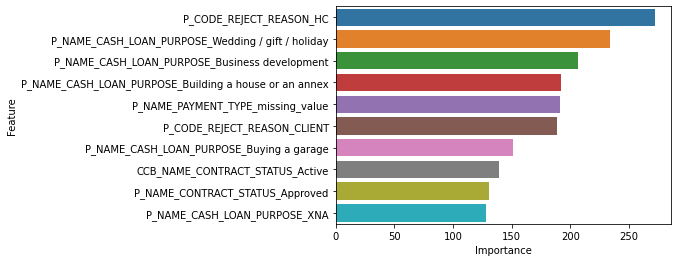

In [97]:
names_num = train_data[numerical_features].columns.values
names_cat = pipe.named_steps['preprocessor'].named_transformers_['categorical'].named_steps["categorical_encoder"].get_feature_names_out(categorical_features)
names = np.concatenate([names_num, names_cat])
imp = pipe.steps[1][1].feature_importances_
data = pd.DataFrame({'Feature': names, 'Importance': imp})
data = data.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=data);


In [98]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])
print_results(y_pred, y_test)

Test ROC AUC score: 0.7088803894052381


In [99]:
import pickle

pkl_filename = "final_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pipe, file)

Here we have final ROC AUC score, but how this model would work in real life situation?

## Business value of this model. 
Firstly I will calculate the mean value of the loans amount with 95% confidence.

In [100]:
df.AMT_CREDIT

mean = df.AMT_CREDIT.mean()
n = len(df)
sd = df.AMT_CREDIT.std()
(mean, n)

tstar = 1.96
standart_error = sd/np.sqrt(n)
standart_error

lcb = round(mean - tstar * standart_error, 0)
ucb = round(mean + tstar * standart_error, 0)
print('Mean value of credit per person: ')
(lcb, ucb)

Mean value of credit per person: 


(597603.0, 600449.0)

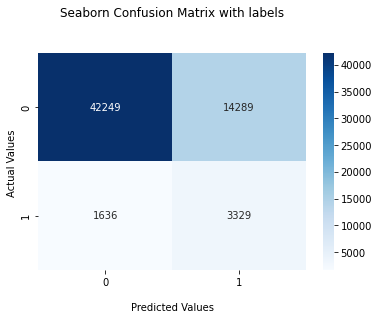

In [101]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])

confm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confm, annot=True, cmap='Blues',fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0 ,1])
ax.yaxis.set_ticklabels([0 ,1])

plt.show()

From the official data we know that Home credit loans has Minimum Annual Percentage Rate (APR): 24%, Maximum APR: 49.5% Minimum repayment period: 6 months, Maximum repayment period: 48 months.

- [0, 0] True Positive - this is good loans with all payments in time.
- [0, 1] False Positive - this is good loans, but predicted as having difficulties. For the creditor, this is missed opportunity and lost interest rate.
- [1, 0] False Negative - difficult loans predicted as good. Money are lent, but bank have difficulty to get it back, I will calculate as lost money.
- [1, 1] True Negative - difficult loans predicted as difficult.

Let's calculate the financial impact of this model.

At first I calculated the current model result when good loans return interest rate and bad loans are lost money.

In [102]:
financial_result = (test_data[label_column].value_counts()[0] * lcb * 0.24)  - (test_data[label_column].value_counts()[1]* lcb)
print ('Out of '+ str(len(y_test)) + ' loans this current model generated: ${:.0f}'.format(financial_result))

Out of 61503 loans this current model generated: $5141847924


In [103]:
financial_result = (confm[0,0]* lcb * 0.24) - (confm[0,1]* lcb * 0.24) - (confm[1,0]* lcb)
print ('Out of '+ str(len(y_test)) + ' loans this model generated: ${:.0f}'.format(financial_result))

Out of 61503 loans this model generated: $3032476663


# Conclusion

If this model would be integrated into automatic decision platform, it can generate thousands of application by itself.
The current model return more profit than my suggested model, however the developed model reduces the risks if loans are not returned. 

This model can be very useful when opening new locations, because it reduces the loss when the company doesn't have big savings in money.
So the new model has advantages and disadvantages, but final decision should be made by Home Credit shareholders.